#  Problem Set 2
**Zhiyu Fu**

## Problem 1

### (a)

In [1]:
%matplotlib notebook
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import integrate

In [2]:
dt = np.loadtxt("incomes.txt")

<IPython.core.display.Javascript object>


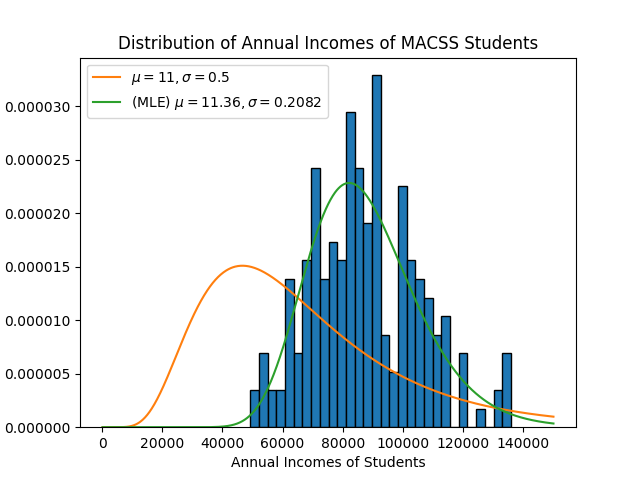

In [3]:
fig, ax = plt.subplots()
ax.hist(dt, bins = 30, normed = True, edgecolor = "Black")
ax.set(xlabel = "Annual Incomes of Students", 
       ylabel = "Density", 
       title = "Distribution of Annual Incomes of MACSS Students")

## (b)

First, construct the class of Log normal distribution.

In [4]:
class Random_Variable:
    def log_lik(self, dt, param = None):
        return np.sum(np.log(self.pdf(dt, param)))
    
    def param_array(self):
        pass
    
    def pdf(self, x, param = None):
        pass
    
    def MLE(self, dt):
        def crit(param):
            return -self.log_lik(dt, param)
        return minimize(crit, self.param_array(), method='L-BFGS-B',
                       bounds = ((None, None), (0.1, None)))
    
    def cdf_integral(self, x):
        return integrate.quad(lambda x: self.pdf(x, param), 0, x)
        

class Log_Normal(Random_Variable):
    def __init__(self, mu, sigma):
        self.mu  = mu
        self.sigma = sigma
    
    def param_array(self):
        return np.array([self.mu, self.sigma])
    
    def pdf(self, x, param = None):
        if param is None:
            sigma = self.sigma
            mu = self.mu
        else:
            mu, sigma = param
        return 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma/sigma)
    
    def cdf(self, x, param = None):
        if param is None:
            sigma = self.sigma
            mu = self.mu
        else:
            mu, sigma = param
        return sts.norm.cdf((np.log(x) - mu)/sigma)

    

In [6]:
lognormal = Log_Normal(11, 0.5)
xval = np.linspace(150000/1000, 150000, 1000)
yval = lognormal.pdf(xval)
ax.plot(xval, yval, label = "$\mu = 11, \sigma = 0.5$")
ax.legend(loc = "best")
plt.show()

See the figure above for the plot.

In [7]:
print("The value of log likelihood for this parameterization is {}:".format(lognormal.log_lik(dt)))

The value of log likelihood for this parameterization is -2385.856997808558:


### (c)

In [8]:
results = lognormal.MLE(dt) # The MLE method is implemented above.
lognormal2 = Log_Normal(*results.x)
xval = np.linspace(150000/1000, 150000, 1000)
yval = lognormal2.pdf(xval)
ax.plot(xval, yval, label = "(MLE) $\mu = {}, \sigma = {}$".format(results.x[0].round(2), results.x[1].round(4)))
ax.legend(loc = "best")
plt.show()

See the figure above for the plot.

In [9]:
print("mu_MLE = {}, sigma_MLE = {}, Log Likelihood = {}".format(results.x[0], results.x[1], -results.fun))
OffDiagNeg = np.array([[1, -1], [-1, 1]])
VCV = results.hess_inv.todense() * OffDiagNeg
print("VCV is:")
print(VCV)

mu_MLE = 11.359024396310758, sigma_MLE = 0.20817852814050342, Log Likelihood = -2241.7193013684946
VCV is:
[[  2.52828885e-04  -2.76199438e-05]
 [ -2.76199438e-05   1.30459506e-04]]


### (d)

In [10]:
chi2val = 2* (- results.fun - lognormal.log_lik(dt))
pval_h0 = 1 - sts.chi2.cdf(chi2val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


Therefore, the data in the incomes.txt are unlikely to come from the distribution in part (b).

### (e)

In [11]:
lognormal_mle = Log_Normal(*results.x)
print("The probability of earning more than $100,000: {}".format((1-lognormal_mle.cdf(100000)).round(2)))
print("The probability of earning less than $75,000: {}".format((lognormal_mle.cdf(75000)).round(2)))

The probability of earning more than $100,000: 0.23
The probability of earning less than $75,000: 0.26


Below is the likelihood function around the maximal point.

<IPython.core.display.Javascript object>


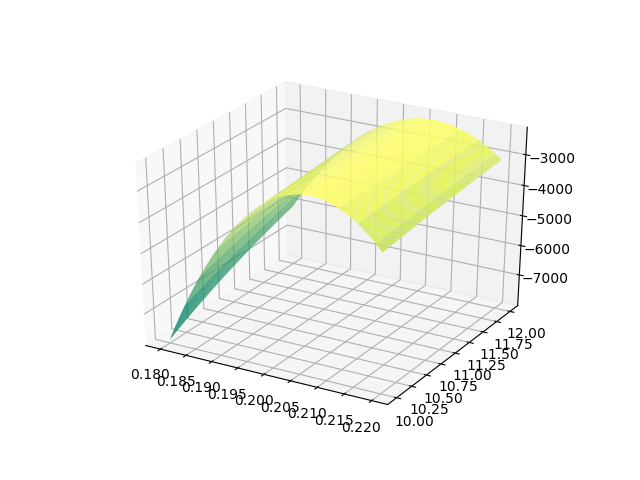

In [12]:
mu_vals = np.linspace(10,12,100)
sig_vals = np.linspace(0.18, 0.22, 100)
lnlik_vals = np.empty((100, 100))
for mu_ind in range(100):
    for sig_ind in range(100):
        param = mu_vals[mu_ind], sig_vals[sig_ind]
        lnlik_vals[mu_ind, sig_ind] = lognormal.log_lik(dt, param)
mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 =cm.get_cmap('summer')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, lnlik_vals, rstride=8,
                cstride=1, cmap=cmap1)

## Part 2 Linear Regression and MLE

In [13]:
import pandas as pd
sick = pd.read_csv("sick.txt")

In [14]:
class Linear_Regression:
    def __init__(self, y, X, constant = True):
        self.y = y
        self.X = X
        self.N = len(y)
        if constant is True:
            self.X = np.concatenate((np.ones((self.N, 1)),self.X), axis = 1)
        self.m = self.X.shape[1]
    
    def log_lik(self, param):
        beta = param[0:self.m]
        sigma2 = param[self.m]
        return -self.N/2*np.log(2*np.pi*sigma2) - 1/2/sigma2*(self.y - self.X @ beta).T @ (self.y - self.X @ beta)

    def MLE(self):
        return minimize(lambda x: -self.log_lik(x), [1,0,0,0,0.01], method='L-BFGS-B',
                       bounds = ((None, None), 
                                (None, None),
                                (None, None),
                                (None, None),
                                (1e-10, None)))
    
    def analy_sol(self):
        X = self.X
        y = self.y
        return np.linalg.inv(X.T@X) @ X.T @ y

### (a)

In [15]:
lr = Linear_Regression(sick.loc[:, "sick"].values, sick.iloc[:, 1:].values)
mle_res = lr.MLE()
Hinv = mle_res.hess_inv.todense()
OffDiagNeg = -np.ones(Hinv.shape) + np.eye(Hinv.shape[0])*2
VCV = Hinv * OffDiagNeg


In [16]:
print("The estimates for beta_0 to sigma^2 are as follows:")
print(mle_res.x)
print("VCV matrix:")
print(VCV)
print("Log Likelihood:")
print(-mle_res.fun)

The estimates for beta_0 to sigma^2 are as follows:
[  2.51644553e-01   1.29335605e-02   4.00500112e-01  -9.99175290e-03
   9.10293751e-06]
VCV matrix:
[[  2.75704726e+03  -1.31994318e+01   3.27180282e+02   5.84202636e+01
   -2.83873640e+00]
 [ -1.31994318e+01   6.81502571e-02   1.60144483e+00   2.82966741e-01
   -1.35541029e-02]
 [  3.27180282e+02   1.60144483e+00   3.90753544e+01  -6.95595770e+00
    3.36606203e-01]
 [  5.84202636e+01   2.82966741e-01  -6.95595770e+00   1.24006007e+00
    6.01269973e-02]
 [ -2.83873640e+00  -1.35541029e-02   3.36606203e-01   6.01269973e-02
    2.92326654e-03]]
Log Likelihood:
876.865062672


### (b)

In [ ]:
chi2val = 2*(-mle_res.fun - lr.log_lik([1, 0,0,0,0.01]))
pval_h0 = 1 - sts.chi2.cdf(chi2val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

The H0 is rejected.